In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    recall_score, precision_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score
)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd

In [30]:
class LogRegCCD:
    def __init__(self, alpha=1.0, lambda_values=None, tol=1e-6, max_iter=1000):
        """
        Regularized Logistic Regression using Coordinate Descent (CCD1) with optimizations.
        
        Parameters:
        alpha - regularization type (1=Lasso, 0=Ridge, 0 < alpha < 1 = Elastic Net)
        lambda_values - list of lambda values for regularization path
        tol - stopping criterion
        max_iter - maximum number of iterations
        """
        self.alpha = alpha
        self.lambda_values = lambda_values
        self.tol = tol
        self.max_iter = max_iter
        self.coefficients = {}
        self.thresholds = {}

    def sigmoid(self, z):
        """ Numerically stable sigmoid function """
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def compute_cost(self, X, y, beta, lmbda):
        """ Compute the logistic loss function with regularization """
        p = self.sigmoid(X @ beta)
        loss = -np.mean(y * np.log(p + 1e-9) + (1 - y) * np.log(1 - p + 1e-9))
        reg = lmbda * (self.alpha * np.sum(np.abs(beta)) + (1 - self.alpha) * np.sum(beta ** 2))
        return loss + reg

    def fit(self, X_train, y_train):
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]  # Bias term
        n_samples, n_features = X_train.shape
        y_train = y_train.reshape(-1)  # Convert to 1D array

        if self.lambda_values is None:
            self.lambda_values = np.logspace(-4, 1, 50)

        self.coefficients = {}

        for lmbda in self.lambda_values:
            beta = np.zeros(n_features)
            cost_old = self.compute_cost(X_train, y_train, beta, lmbda)

            for iteration in range(self.max_iter):
                beta_old = beta.copy()
                y_hat = self.sigmoid(X_train @ beta)
                residual = y_train - y_hat  

#                 # 1. Wybór najlepszego `j` (Greedy Feature Selection) 
                 # w poleceniu zadania napisali: It is not necessary to use all the speed-up tricks described in the article, although speeding up the method will count as a plus.
                
        # Greedy Feature Selection można przetestować ( odhaszować to, a zahaszować od for j in range do 2.)
        
#                 gradients = np.abs(np.dot(X_train.T, residual) / n_samples)
#                 j = np.argmax(gradients)  # Wybór współczynnika o największym gradiencie

#                 z_j = X_train[:, j]
#                 gradient = np.dot(z_j, residual) / n_samples
#                 shrinkage = self.alpha * lmbda
#                 denom = np.sum(z_j ** 2) + (1 - self.alpha) * lmbda  # L2 component

#                 # Soft-thresholding update
#                 S_j = np.sign(gradient) * max(abs(gradient) - shrinkage, 0)
#                 beta[j] = S_j / denom
                for j in range(n_features):
                    z_j = X_train[:, j]
                    gradient = np.dot(z_j, residual) / n_samples
                    shrinkage = self.alpha * lmbda
                    denom = np.sum(z_j ** 2) + (1 - self.alpha) * lmbda  # L2 component

                    # Soft-thresholding update
                    S_j = np.sign(gradient) * max(abs(gradient) - shrinkage, 0)
                    beta[j] = S_j / denom

                # 2. Opóźniona aktualizacja 'residual' (Lazy Updates)
                if iteration % 5 == 0:
                    residual = y_train - self.sigmoid(X_train @ beta)

                # 3. Warunek zatrzymania oparty na funkcji kosztu (Cost-based Convergence)
                cost_new = self.compute_cost(X_train, y_train, beta, lmbda)
                if abs(cost_old - cost_new) < self.tol:
                    print(f"Lambda={lmbda}: Converged after {iteration + 1} iterations.")
                    break
                cost_old = cost_new  # Aktualizacja wartości funkcji kosztu

            self.coefficients[lmbda] = beta.copy()

    def predict_proba(self, X_test, lambda_value=None):
        X_test = np.c_[np.ones(X_test.shape[0]), X_test]

        if lambda_value is None:
            lambda_value = list(self.coefficients.keys())[-1]  

        closest_lambda = min(self.coefficients.keys(), key=lambda x: abs(x - lambda_value))
        beta = self.coefficients[closest_lambda]
        return self.sigmoid(X_test @ beta)

    def validate(self, X_valid, y_valid, measure='roc_auc'):
        X_valid = np.c_[np.ones(X_valid.shape[0]), X_valid]
        best_lambda = None
        best_score = float('-inf')
        scores = {}

        for lmbda, beta in self.coefficients.items():
            y_probs = self.sigmoid(X_valid @ beta)

            if measure == 'roc_auc':
                score = roc_auc_score(y_valid, y_probs)
            elif measure == 'pr_auc':
                score = average_precision_score(y_valid, y_probs)
            else:
                threshold = 0.5
                y_pred = (y_probs >= threshold).astype(int)

                if measure == 'recall':
                    score = recall_score(y_valid, y_pred)
                elif measure == 'precision':
                    score = precision_score(y_valid, y_pred)
                elif measure == 'f1':
                    score = f1_score(y_valid, y_pred)
                elif measure == 'balanced_accuracy':
                    score = balanced_accuracy_score(y_valid, y_pred)
                else:
                    raise ValueError(f"Invalid metric chosen: {measure}")

            scores[lmbda] = score
            if score > best_score:
                best_lambda, best_score = lmbda, score

        return best_lambda, best_score

    def plot_coefficients(self):
        plt.figure(figsize=(8, 5))
        for i in range(len(next(iter(self.coefficients.values())))):
            plt.plot(self.lambda_values, [coef[i] for coef in self.coefficients.values()], label=f'Feature {i}')
        plt.xscale('log')
        plt.xlabel("Lambda")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient Paths")
        plt.legend()
        plt.grid()
        plt.show()

In [31]:
#przykład użycia:

Lambda=0.0001: Converged after 2 iterations.
Lambda=0.0001623776739188721: Converged after 2 iterations.
Lambda=0.00026366508987303583: Converged after 2 iterations.
Lambda=0.00042813323987193956: Converged after 2 iterations.
Lambda=0.0006951927961775605: Converged after 2 iterations.
Lambda=0.0011288378916846883: Converged after 2 iterations.
Lambda=0.0018329807108324356: Converged after 2 iterations.
Lambda=0.002976351441631319: Converged after 2 iterations.
Lambda=0.004832930238571752: Converged after 2 iterations.
Lambda=0.007847599703514606: Converged after 2 iterations.
Lambda=0.012742749857031334: Converged after 2 iterations.
Lambda=0.0206913808111479: Converged after 2 iterations.
Lambda=0.03359818286283781: Converged after 2 iterations.
Lambda=0.05455594781168514: Converged after 2 iterations.
Lambda=0.08858667904100823: Converged after 2 iterations.
Lambda=0.14384498882876628: Converged after 2 iterations.
Lambda=0.23357214690901212: Converged after 2 iterations.
Lambda=0.3

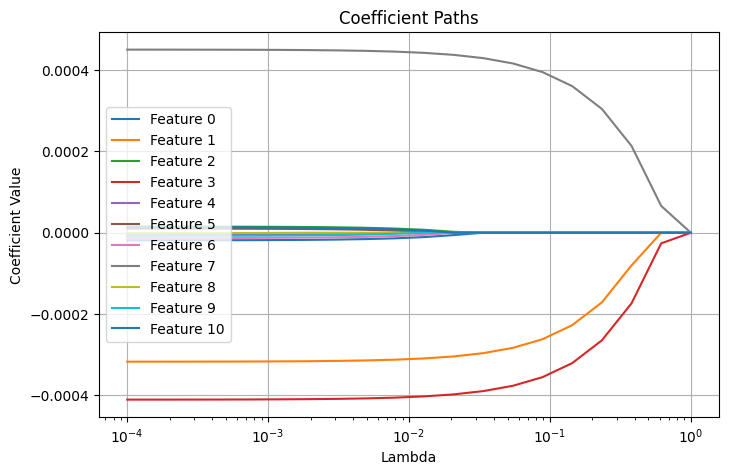

In [32]:
# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scalling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
#Model = LogRegCCD(alpha=1.0, lambda_values=np.logspace(-3, 1, 20), max_iter=1000, tol=1e-6)
model = LogRegCCD(alpha=0.5, lambda_values=np.logspace(-4, 0, 20), max_iter=1000, tol=1e-6) # popróbować dla alpha=1.0, 0.0, 0.5

model.fit(X_train, y_train)

# Predict probabilities
probs = model.predict_proba(X_test, lambda_value=0.1)
print("Predictions:", probs[:10])

# Validate model
best_lambda, best_score = model.validate(X_test, y_test, measure="roc_auc")
print(f"📊 Best lambda: {best_lambda}, ROC-AUC: {best_score:.4f}")

# Plot coefficient paths
model.plot_coefficients()

                   Best Lambda  Best Score
precision             0.615848    0.887755
recall                1.000000    1.000000
f1                    0.615848    0.832536
balanced_accuracy     0.615848    0.830094
pr_auc                0.615848    0.937919
roc_auc               0.615848    0.906063


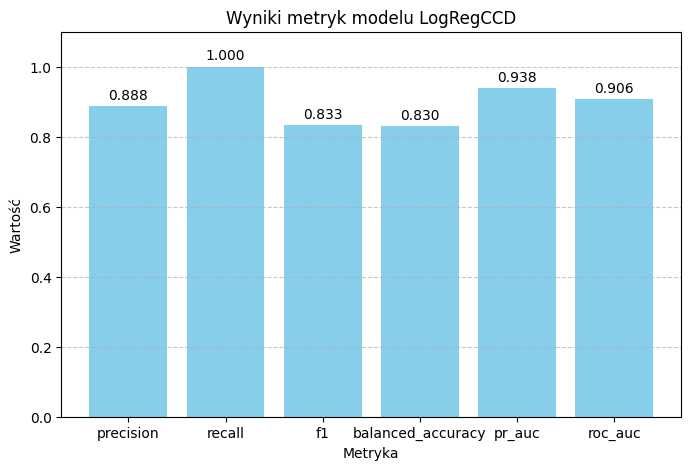

In [33]:
# Validation for different metrics
metrics = ["precision", "recall", "f1", "balanced_accuracy", "pr_auc", "roc_auc"]
validation_results = {}

for metric in metrics:
    best_lambda, best_score = model.validate(X_test, y_test, measure=metric)
    validation_results[metric] = {
        "Best Lambda": best_lambda,
        "Best Score": best_score
    }


df_results = pd.DataFrame.from_dict(validation_results, orient="index")

print(df_results)

# Plot
metrics = list(validation_results.keys())
scores = [validation_results[m]["Best Score"] for m in metrics]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel("Metryka")
plt.ylabel("Wartość")
plt.title("Wyniki metryk modelu LogRegCCD")
plt.ylim(0, 1.1)  # Scale from 0 to 1.1 for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center', fontsize=10)

plt.show()

In [34]:
y_probs = model.predict_proba(X_test, lambda_value=0.1)  # Predykcja prawdopodobieństw
y_pred = (y_probs >= 0.5).astype(int)  # Przekształcenie na klasy 0/1

print("Liczba przewidzianych 1:", np.sum(y_pred))
print("Liczba przewidzianych 0:", len(y_pred) - np.sum(y_pred))

Liczba przewidzianych 1: 100
Liczba przewidzianych 0: 100


In [35]:
# szybkie porównanie: (można się bawić wartościami w (-3, 1, 20))

In [36]:
# LASSO (L1)
model_lasso = LogRegCCD(alpha=1.0, lambda_values=np.logspace(-3, 1, 20))
model_lasso.fit(X_train, y_train)

# Ridge (L2)
model_ridge = LogRegCCD(alpha=0.0, lambda_values=np.logspace(-3, 1, 20))
model_ridge.fit(X_train, y_train)

# Elastic Net (50% L1, 50% L2)
model_elastic = LogRegCCD(alpha=0.5, lambda_values=np.logspace(-3, 1, 20))
model_elastic.fit(X_train, y_train)

Lambda=0.001: Converged after 2 iterations.
Lambda=0.001623776739188721: Converged after 2 iterations.
Lambda=0.0026366508987303583: Converged after 2 iterations.
Lambda=0.004281332398719396: Converged after 2 iterations.
Lambda=0.0069519279617756054: Converged after 2 iterations.
Lambda=0.011288378916846888: Converged after 2 iterations.
Lambda=0.018329807108324356: Converged after 2 iterations.
Lambda=0.029763514416313176: Converged after 2 iterations.
Lambda=0.04832930238571752: Converged after 2 iterations.
Lambda=0.07847599703514611: Converged after 2 iterations.
Lambda=0.12742749857031335: Converged after 2 iterations.
Lambda=0.20691380811147903: Converged after 2 iterations.
Lambda=0.3359818286283781: Converged after 1 iterations.
Lambda=0.5455594781168515: Converged after 1 iterations.
Lambda=0.8858667904100823: Converged after 1 iterations.
Lambda=1.438449888287663: Converged after 1 iterations.
Lambda=2.3357214690901213: Converged after 1 iterations.
Lambda=3.792690190732246:

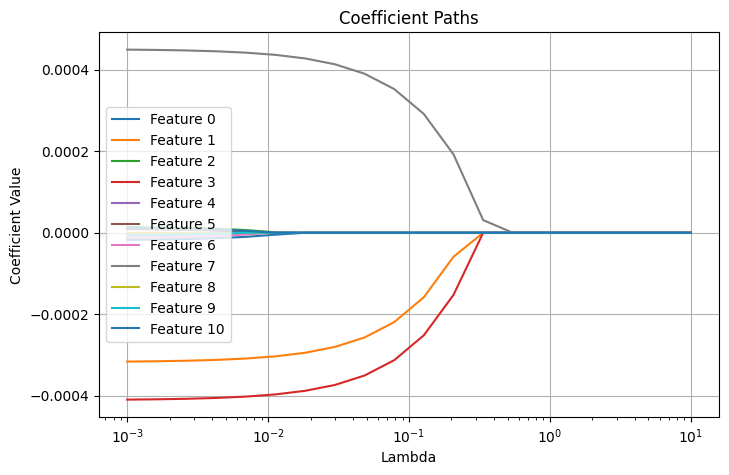

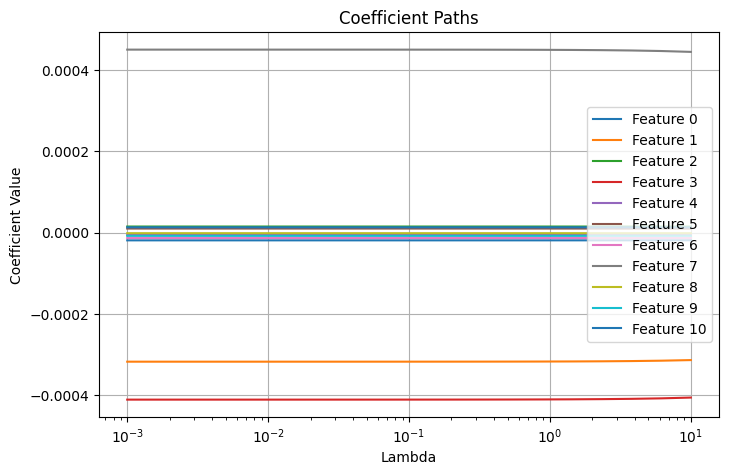

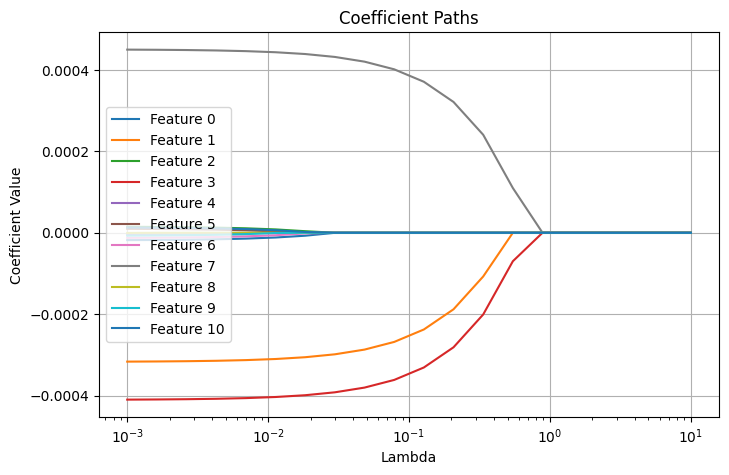

In [37]:
# Wykres współczynników beta dla różnych alpha
model_lasso.plot_coefficients()
model_ridge.plot_coefficients()
model_elastic.plot_coefficients()